<!-- 
# Bathe Model Problem
-->

> March 2020, By Amir Hossein Namadchi

This is an OpenSeesPy simulation of a simple linear 3 DOF system introduced by [Bathe and Noh](https://www.sciencedirect.com/science/article/abs/pii/S0045794912000107). The model was used to demonstrate the ability of Bathe method in filtering out the unwanted artificial high-frequency responses. The effectiveness of numerical dissipation in a specific time integration algorithm could be evaluated by analyzing this benchmark model problem [[1]](https://link.springer.com/article/10.1007/s00366-020-00960-w).

![ModelProblem](ModelProblem.png)

In [11]:
import numpy as np
import opensees.openseespy as ops
import matplotlib.pyplot as plt

No units were defined in the original paper. So, I just assume the base units as follows:

In [12]:
## Units
m = 1               # Meters
KN = 1              # KiloNewtons
s = 1               # Seconds

kg = KN*(s**2)/m    # mass unit (derived)

Model specifications are defined as follows:

In [13]:
# Nodal mass values
m_1, m_2, m_3 = 0*kg, 1*kg, 1*kg

# Modulus of Elasticity
E_1 = (10.0**7)*(KN/m**2)
E_2 = 1.0*(KN/m**2)

# Prescribed displacment @ node 1
d_p = lambda t: np.sin(1.2*t)*m

In [14]:
# Dynamic Analysis Parameters
dt = 0.2618
time = 10

Here's the exact solution for comparison. It can be obtained using modal decomposition technique, considering only the lowest frequency plus the static correction [[1]](https://link.springer.com/article/10.1007/s00366-020-00960-w).

In [15]:
d_2_ex = lambda t : (2.7273e-7)*np.sin(t) + np.sin(1.2*t)
d_3_ex = lambda t : (2.7273)*np.sin(t) - (2.2727)*np.sin(1.2*t)

v_2_ex = lambda t : (2.7273e-7)*np.cos(t) + 1.2*np.cos(1.2*t)
v_3_ex = lambda t : (2.7273)*np.cos(t) - 1.2*(2.2727)*np.cos(1.2*t)

a_2_ex = lambda t : -(2.7273e-7)*np.sin(t) - 1.2*1.2*np.sin(1.2*t)
a_3_ex = lambda t : -(2.7273)*np.sin(t) + 1.2*1.2*(2.2727)*np.sin(1.2*t)

### Model Construction
Use `ZeroLength` elements to model the spings. Note that nodal masses are added via `mass` option of the `node` command.

In [16]:
def build_model():
    
    model = ops.Model(ndm=1, ndf=1)

    # Adding nodes
    for n, mass in enumerate([m_1,m_2,m_3]):
        model.node(n+1, 0.0, mass=mass)

    # Defining Material (spring stiffness)
    model.uniaxialMaterial('Elastic', 1, E_1)
    model.uniaxialMaterial('Elastic', 2, E_2)

    # Add springs
    model.element('ZeroLength', 1, (1,2), '-mat', 1, '-dir', 1)
    model.element('ZeroLength', 2, (2,3), '-mat', 2, '-dir', 1)

    return model

### Dynamic Analysis
To use different time integration algorithms, the function `do_dynamic_analysis` is defined. Here, `Newmark` with $\gamma=0.5$ and $\beta=0.25$ (a non-dissipative algorithm) and [the Bathe method](http://web.mit.edu/kjb/www/Principal_Publications/On_a_Composite_Implicit_Time_Integration_Procedure_for_Nonlinear_Dynamics.pdf), named `'TRBDF2'` (with asymptotic annihilation property) are used.



In [ ]:
def do_dynamic_analysis(time, dt, integrator_params):
    
    model = build_model()
    time_domain = np.arange(0,time,dt)


    # Constraints
    model.timeSeries('Path', 1,
                    dt=dt,
                    values=np.vectorize(d_p)(time_domain),
                    time=time_domain)
    model.pattern('Plain', 1, 1)
    model.sp(1, 1, 1)

    # Analysis
    model.constraints('Transformation')
    model.numberer('Plain')
    model.system('ProfileSPD')
    model.algorithm('Linear')
    model.integrator(*integrator_params)
    model.analysis('Transient')

    time_lst =[0]           # list to hold time stations for plotting
    res_node_2 = [[0,0,0]]  # response params of node 2     
    res_node_3 = [[0,0,0]]  # response params of node 3

    for i in range(len(time_domain)):
        model.analyze(1, dt)
        time_lst.append(model.getTime())
        res_node_2.append([model.nodeDisp(2,1),
                           model.nodeVel(2,1),
                           model.nodeAccel(2,1)])
        res_node_3.append([model.nodeDisp(3,1),
                           model.nodeVel(3,1),
                           model.nodeAccel(3,1)])
    
    return {'time_list':np.array(time_lst),
            'Node 2': np.array(res_node_2), 
            'Node 3': np.array(res_node_3)}

Let's perform analysis:

In [18]:
newmark = do_dynamic_analysis(time, dt,['Newmark',0.5,0.25])
bathe = do_dynamic_analysis(time, dt,['TRBDF2'])

Done with  Newmark !
Done with  TRBDF2 !


### Visualization

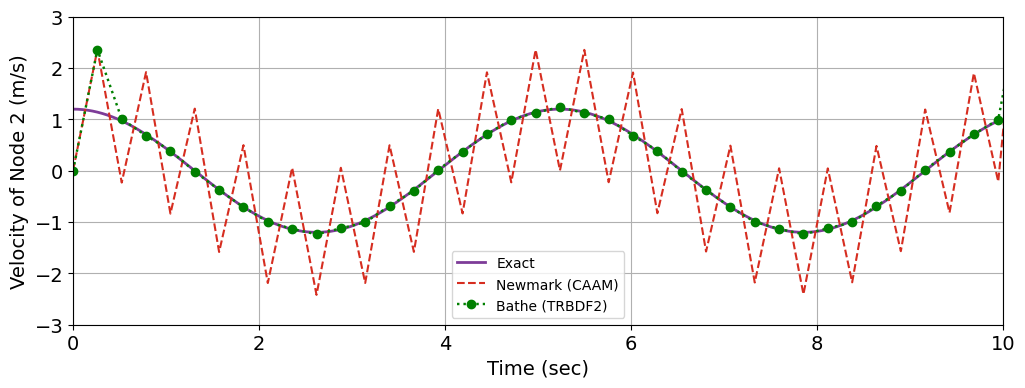

In [19]:
plt.figure(figsize=(12,4))
plt.plot(np.arange(0, time, 0.2*dt),
         np.vectorize(v_2_ex)(np.arange(0,time,0.2*dt)),
         color = '#7D3C98', linewidth = 2, label = 'Exact')
plt.plot(newmark['time_list'], newmark['Node 2'][:,1],
         color = '#d62d20', linewidth=1.5, ls='--', label = 'Newmark (CAAM)' )
plt.plot(bathe['time_list'], bathe['Node 2'][:,1],
         color = '#008000', linewidth=1.75, label = 'Bathe (TRBDF2)', marker = 'o',ls=':')

plt.ylabel('Velocity of Node 2 (m/s)', {'size':14})
plt.xlabel('Time (sec)', {'size':14})
plt.xlim([0.0, time])
plt.ylim([-3, 3])
plt.grid()
plt.legend()
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14);

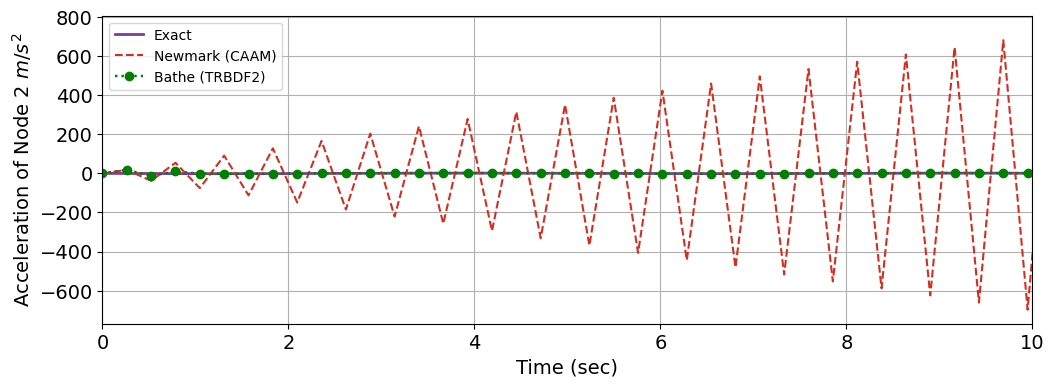

In [20]:
plt.figure(figsize=(12,4))
plt.plot(np.arange(0, time, 0.2*dt),
         np.vectorize(a_2_ex)(np.arange(0,time,0.2*dt)),
         color = '#7D3C98', linewidth = 2, label = 'Exact')
plt.plot(newmark['time_list'], newmark['Node 2'][:,2],
         color = '#d62d20', linewidth=1.5, ls='--', label = 'Newmark (CAAM)' )
plt.plot(bathe['time_list'], bathe['Node 2'][:,2],
         color = '#008000', linewidth=1.75, label = 'Bathe (TRBDF2)', marker = 'o',ls=':')

plt.ylabel('Acceleration of Node 2 $m/s^2$', {'size':14})
plt.xlabel('Time (sec)', {'size':14})
plt.xlim([0.0, time])
#plt.ylim([-30, 30])
plt.grid()
plt.legend()
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14);



### Closure
As expected, non-dissipative methods like CAAM are unable to represent the exact response due to spurious high frequency oscillations. 
On the other hand, the `TRBDF2` scheme can effectively damp out these oscillations via algorithmic damping.

### References
- Bathe, K.J. and Noh, G., 2012. Insight into an implicit time integration scheme for structural dynamics. Computers & Structures, 98, pp.1-6.
- Namadchi, A.H., Jandaghi, E. and Alamatian, J., 2020. A new model-dependent time integration scheme with effective numerical damping for dynamic analysis. Engineering with Computers, pp.1-16.